## Introduction

In this notebook I look into Airbnb Boston Data to explore its business growth, prices, availability and ratings.

calendar data: home availability data from September 2016 to September 2017.
listing data: home information data from January 2016 to January 2017 on 3,818 homes.
reviews data: house reviews between June 2009 and January 2016.
The question I try to answer in this notebook include:

1. What’s the home availability pattern?
2. How price and rating relate with each other?
3. What’s the major factor that influence price and ratings?

In [1]:
#Importing various packages 
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Accessing Data

In [2]:
reviews = pd.read_csv("reviews.csv")
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [3]:
listings = pd.read_csv("listings.csv")
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [5]:
calendar = pd.read_csv("calendar.csv")
calendar.head(2)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


### Cleaning the data

To perform clean this dataset, the following is done:
1. Change the date column from an object to datetime
2. Remove the dollar sign from the price

In [7]:
# str to datetime
to_datetime = lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d')
# remove sign
def remove_sign(column,sign):
    if type(column) is str:
        column = float(column.replace(sign,'').replace(',',''))
    return column


In [8]:
# Cleaning the listing data
listings['host_since'] = listings.host_since.apply(to_datetime)
listings['price'] = listings.price.apply(remove_sign,sign='$')
listings['host_response_rate'] = listings.host_response_rate.apply(remove_sign,sign='%')
listings['host_acceptance_rate'] = listings.host_acceptance_rate.apply(remove_sign,sign='%')

In [9]:
#Cleaning the calendar data
calendar['date'] = calendar['date'].apply(to_datetime)
calendar['price'] = calendar.price.apply(remove_sign,sign='$')
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308890 non-null  int64         
 1   date        1308890 non-null  datetime64[ns]
 2   available   1308890 non-null  object        
 3   price       643037 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 39.9+ MB


## Q1: Home Availability Pattern

In [10]:
# total number of available home each day
avaliable_houses = calendar.groupby('date').apply(lambda x: x.notnull().sum())[['price']]
# change column name
avaliable_houses = avaliable_houses.rename({"price":"total_available_houses"},axis='columns')

In [11]:
# everyday average prices
calendar_open = calendar[calendar['price'].notnull()]
# average house price for boston everyday
average_price = calendar_open.groupby('date').mean()[['price']]
# change column name
average_price = average_price.rename({"price":"average_prices"},axis='columns')

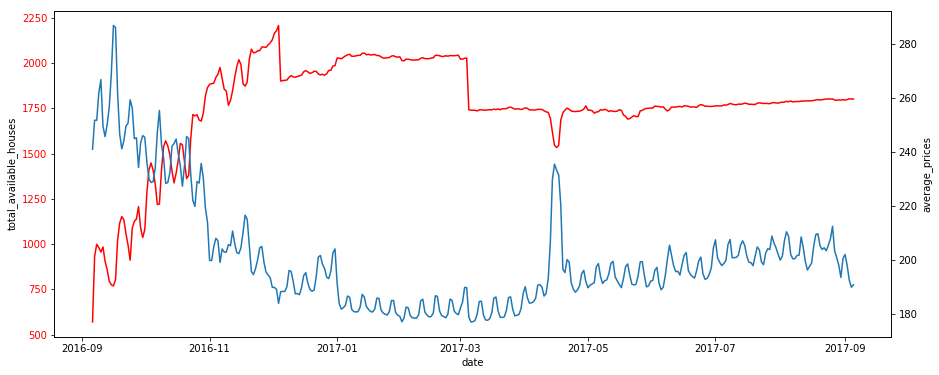

In [12]:
# plot total available houses and average prices in one figure
f, ax = plt.subplots(figsize=(15, 6))
plt1 = sns.lineplot(x = avaliable_houses.index,y = 'total_available_houses', 
                  data = avaliable_houses,color="r",legend=False)
for tl in ax.get_yticklabels():
    tl.set_color('r')

ax2 = ax.twinx()
plt2 = sns.lineplot(x = average_price.index,y = 'average_prices',
             data=average_price,ax=ax2,linestyle=':', legend=False)

## Figure Findings

*Total available houses:*

1. Availability is not stable all year round.
2. Increase from Sep to Nov.
3. Remain relatively stable from 01/2017-09/2017, although the reason why there are two sudden drop of home supply is unclear.

*Average prices:*

1. Price drop as home supply increase from 09/2016 to 12/2016.
2. The sudden drop of supply in 03/2017 dose not drive price up;However the sudden drop of supply before 05/2017 just rocket price up. So I guess it has something to do with demand change.
3. There seems to have a small periodical price moving circle and this maybe correspond to weekends.

In [13]:
#Taking indepth look at the price spike before 05/2017
average_price_sub = average_price[average_price.index > '2017-03-1']
average_price_sub[average_price_sub.average_prices == max(average_price_sub.average_prices)]

,average_prices
date,
2017-04-15,235.501618


In [14]:
# average avaliablity for each house
avaliable_days = calendar.groupby('listing_id').apply(lambda x: x.notnull().mean())[['price']]
# change column name
avaliable_days = avaliable_days.rename({"price":"avaliable_ratio"},axis='columns')

C:\Users\kenny\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'count')

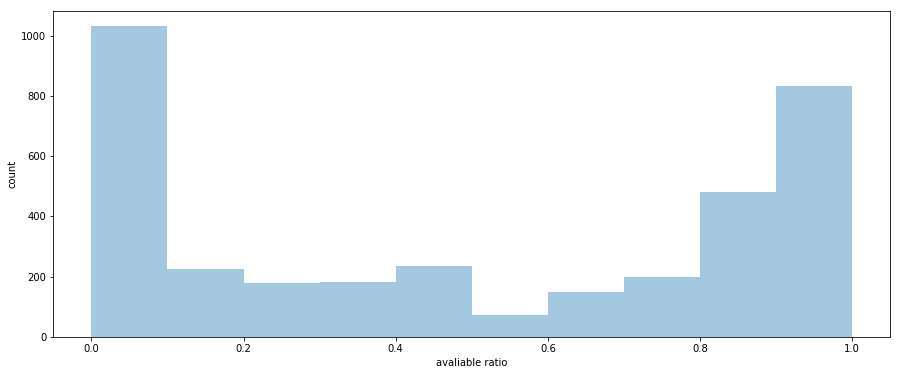

In [15]:
#avaliable_days_bs.head()
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.distplot(avaliable_days, kde=False)
ax.set_xlabel('avaliable ratio', fontsize=10)
ax.set_ylabel('count', fontsize=10)

Most Boston host just list their homes for a small portion of year.

In [16]:
# check general price distribution
calendar_open.describe()

,listing_id,price
count,6.430370e+05,643037.000000
mean,7.699288e+06,198.438909
std,4.766178e+06,180.142913
min,3.353000e+03,11.000000
25%,3.616081e+06,85.000000
50%,7.789055e+06,150.000000
75%,1.228796e+07,255.000000
max,1.493346e+07,7163.000000


C:\Users\kenny\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


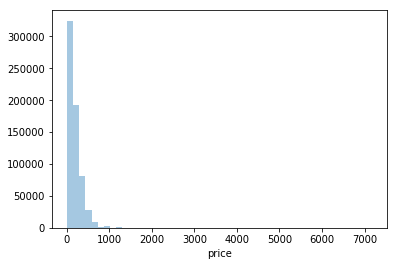

In [17]:
sns.distplot(calendar_open.price, kde=False)

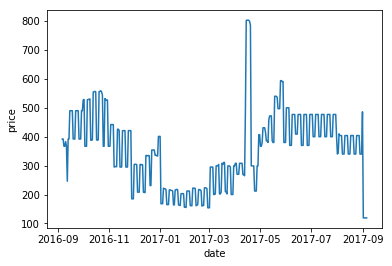

In [19]:
list_price_eg = calendar_open[calendar_open.listing_id == 14421304]
sns.lineplot(x="date",y="price", data=list_price_eg)

## Q2: How price and rating relate with each other?

In [24]:
# use 25% price value as low price bar; 75% price value as high price bar
def price_level(x,low_bar=85,high_bar=220):
    if x<=low_bar:
        x='Low_Price'
    elif x>=high_bar:
        x='High_Price'
    else:
        x='Medium_Price'
    return x
listings['price_level'] = listings.price.apply(price_level)

In [25]:
price_rate = listings[["id","price","review_scores_rating","number_of_reviews","price_level"]].dropna()
price_rate.head()

,id,price,review_scores_rating,number_of_reviews,price_level
1,3075044,65.0,94.0,36,Low_Price
2,6976,65.0,98.0,41,Low_Price
3,1436513,75.0,100.0,1,Low_Price
4,7651065,79.0,99.0,29,Low_Price
5,12386020,75.0,100.0,8,Low_Price


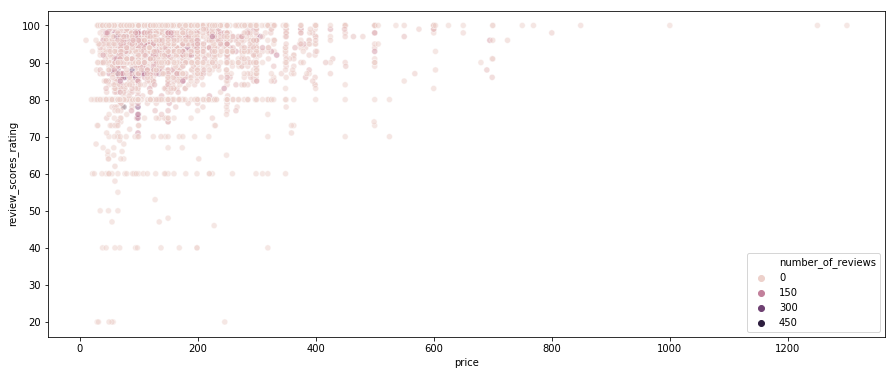

In [26]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='price',y='review_scores_rating',hue='number_of_reviews',alpha=0.5,data=price_rate)

*Figure Facts*
1. Low ratings are associate with lower prices.
2. However high rating dose not mean high price

In [27]:
price_level_review = price_rate.groupby('price_level').mean()
price_level_review

,id,price,review_scores_rating,number_of_reviews
price_level,,,,
High_Price,6.871373e+06,319.172363,92.867756,17.621100
Low_Price,8.224141e+06,64.333787,90.092643,27.528610
Medium_Price,7.678633e+06,146.538462,92.428571,26.479853


In [28]:
price_rate.describe()

,id,price,review_scores_rating,number_of_reviews
count,2.772000e+03,2772.000000,2772.000000,2772.000000
mean,7.627088e+06,166.684343,91.916667,24.606782
std,4.386274e+06,112.972898,9.531686,38.730995
min,3.353000e+03,11.000000,20.000000,1.000000
25%,4.078974e+06,85.000000,89.000000,3.000000
50%,7.713772e+06,145.000000,94.000000,10.000000
75%,1.175728e+07,215.000000,98.250000,29.000000
max,1.484378e+07,1300.000000,100.000000,404.000000


In [29]:
# find the listing with the highest number of reviews
max_id = price_rate[price_rate.number_of_reviews == max(price_rate.number_of_reviews)]
max_id

,id,price,review_scores_rating,number_of_reviews,price_level
414,66288,75.0,78.0,404,Low_Price


In [30]:
# info of this listing
listings[listings.id== 66288].T

,414
id,66288
listing_url,https://www.airbnb.com/rooms/66288
scrape_id,20160906204935
last_scraped,2016-09-07
name,Architects Live-in Studio in Boston
...,...
require_guest_profile_picture,f
require_guest_phone_verification,f
calculated_host_listings_count,7
reviews_per_month,5.87


In [31]:
calendar[calendar.listing_id==66288 ].count()

listing_id    365
date          365
available     365
price         281
dtype: int64

## Q3: What’s the major factor that influence price and ratings?

In [32]:
# keep listings with not null prices
listing_price = listings[listings.price.notnull()]

In [33]:
def plot_price_by_cat(colname,listings=listings,fig_row_size=11,fig_col_size=9):
    price_col = listing_price.groupby(colname).mean()[['price']]
    price_col.reset_index(inplace=True)
    f, ax = plt.subplots(figsize=(fig_row_size, fig_col_size))
    sns.barplot(y=colname,x='price',data=price_col.sort_values(by='price', ascending=False))

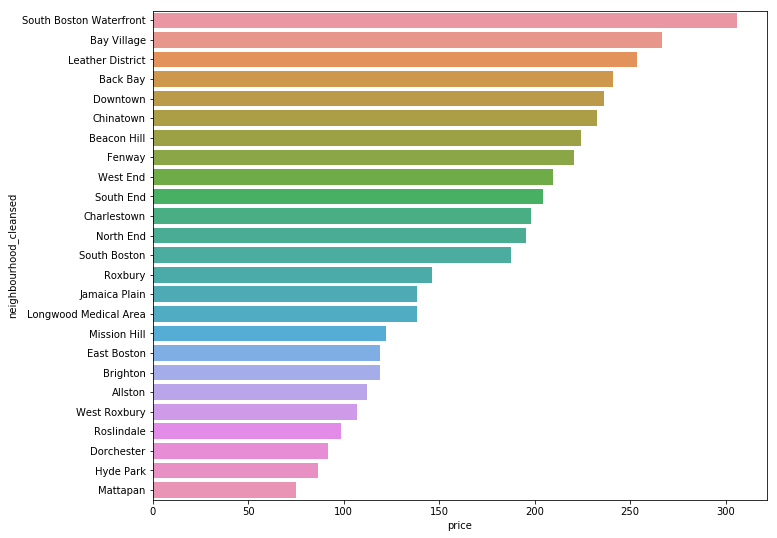

In [34]:
# price and neighborhood
plot_price_by_cat('neighbourhood_cleansed',listings=listing_price)

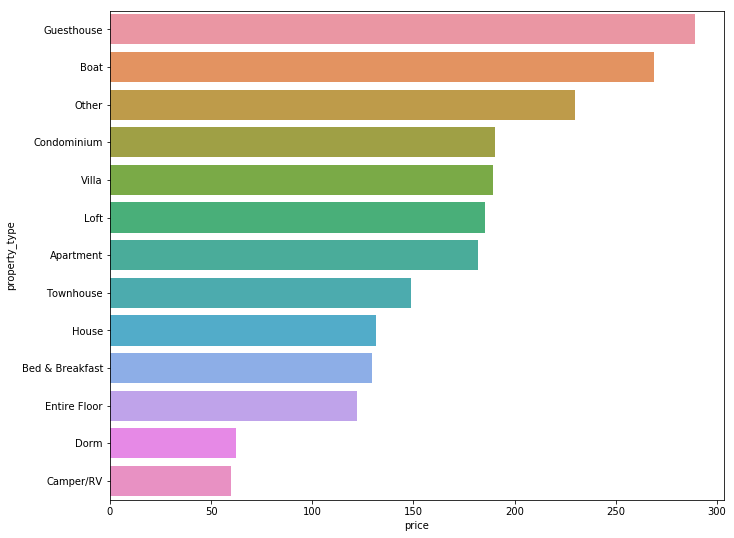

In [35]:
plot_price_by_cat('property_type',listings=listing_price)

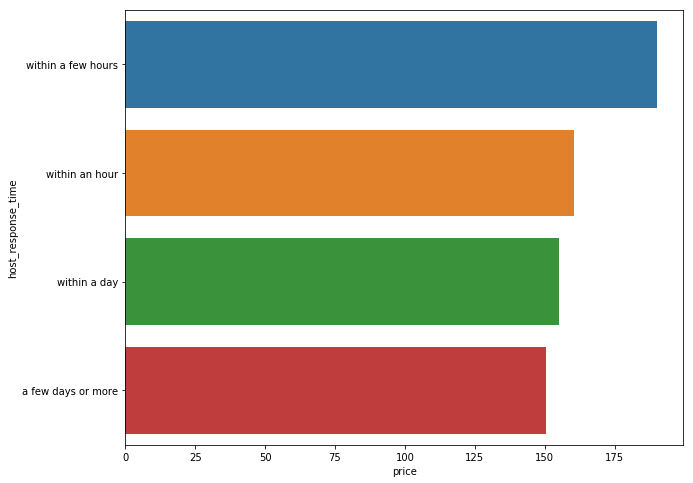

In [36]:
plot_price_by_cat('host_response_time',listings=listing_price,fig_row_size=10,fig_col_size=8)

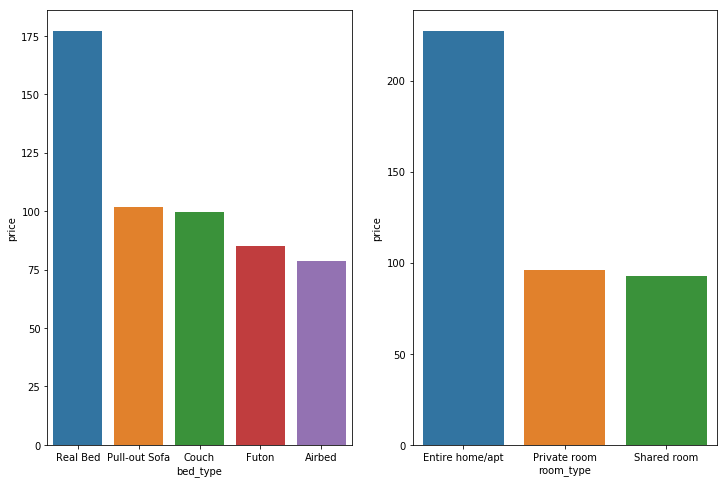

In [37]:
# price and bed_type
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
price_bed_type = listing_price.groupby('bed_type').mean()[['price']]
price_bed_type.reset_index(inplace=True)
sns.barplot(x='bed_type',y='price',data=price_bed_type.sort_values(by='price', ascending=False),ax=ax1)
# price and bed_type
price_room_type = listing_price.groupby('room_type').mean()[['price']]
price_room_type.reset_index(inplace=True)
sns.barplot(x='room_type',y='price',data=price_room_type.sort_values(by='price', ascending=False),ax=ax2)

In [42]:
# see how numerical values correlate with price
listing_price_num = listing_price.select_dtypes(include=['float64','int64'])
listing_price_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3585 non-null   int64  
 1   scrape_id                       3585 non-null   int64  
 2   host_id                         3585 non-null   int64  
 3   host_response_rate              3114 non-null   float64
 4   host_acceptance_rate            3114 non-null   float64
 5   host_listings_count             3585 non-null   int64  
 6   host_total_listings_count       3585 non-null   int64  
 7   neighbourhood_group_cleansed    0 non-null      float64
 8   latitude                        3585 non-null   float64
 9   longitude                       3585 non-null   float64
 10  accommodates                    3585 non-null   int64  
 11  bathrooms                       3571 non-null   float64
 12  bedrooms                        35

In [40]:
# drop irrelevent colunms
listing_price_num = listing_price_num.drop(['latitude','longitude',
                                                  'jurisdiction_names','neighbourhood_group_cleansed',
                                                  'license','has_availability','neighbourhood_group_cleansed'], axis=1)